# Notebook du rapport de classification | Stanford dogs dataset
## Adrian Rodriguez
## Projet 6 parcours Ingénieur Machine Learning
Accès projet git : https://github.com/Adrian1903/Classez-des-images-l-aide-d-algorithmes-de-Deep-Learning  
Plus d'informations : https://openclassrooms.com/fr/paths/148-ingenieur-machine-learning

---
# 0. Contexte

Vous êtes bénévole pour l'association de protection des animaux de votre quartier. C'est d'ailleurs ainsi que vous avez trouvé votre compagnon idéal, Snooky. Vous vous demandez donc ce que vous pouvez faire en retour pour aider l'association.

Vous apprenez, en discutant avec un bénévole, que leur base de données de pensionnaires commence à s'agrandir et qu'ils n'ont pas toujours le temps de référencer les images des animaux qu'ils ont accumulées depuis plusieurs années. Ils aimeraient donc obtenir un algorithme capable de classer les images en fonction de la race du chien présent sur l'image.

## Les données
Les bénévoles de l'association n'ont pas eu le temps de réunir les différentes images des pensionnaires dispersées sur leurs disques durs. Pas de problème, vous entraînerez votre algorithme en utilisant le Stanford Dogs Dataset.

## Votre mission
L'association vous demande de réaliser un algorithme de détection de la race du chien sur une photo, afin d'accélérer leur travail d’indexation.

Vous avez peu d’expérience sur le sujet, vous décidez donc de contacter un ami expert en classification d’images.

Il vous conseille dans un premier temps de pré-processer des images avec des techniques spécifiques (e.g. whitening, equalization, éventuellement modification de la taille des images) et de réaliser de la data augmentation (mirroring, cropping...).

Ensuite, il vous incite à mettre en œuvre deux approches s’appuyant sur l’état de l’art et l’utilisation de CNN (réseaux de neurones convolutionnels), que vous comparerez en termes de temps de traitement et de résultat :

* Une première en réalisant votre propre réseau CNN, en vous inspirant de réseaux CNN existants. Prenez soin d'optimiser certains hyperparamètres (des layers du modèle, de la compilation du modèle et de l’exécution du modèle)
* Une deuxième en utilisant le transfer learning, c’est-à-dire en utilisant un réseau déjà entraîné, et en le modifiant pour répondre à votre problème.

Concernant le transfer learning, votre ami vous précise que :

* Une première chose obligatoire est de réentraîner les dernières couches pour prédire les classes qui vous intéressent seulement.
* Il est également possible d’adapter la structure (supprimer certaines couches, par exemple) ou de réentraîner le modèle avec un très faible learning rate pour ajuster les poids à votre problème (plus long) et optimiser les performances.

## Ressources de calcul
Votre ami vous alerte sur le fait que l'entraînement (même partiel) d'un réseau de neurones convolutionnels est très gourmand en ressources. Si le processeur de l’ordinateur un peu ancien de l’association ne suffit pas, il vous propose plusieurs solutions :

* Limitez le jeu de données, en ne sélectionnant que quelques classes (races de chiens), ce qui permettra déjà de tester la démarche et la conception des modèles, avant une éventuelle généralisation.
* Utilisez la carte graphique de l’ordinateur en tant que GPU (l'installation est un peu fastidieuse, et l'ordinateur est inutilisable le temps du calcul).

Ce notebook aide à l'interprétation des erreurs ayant lieu en production

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use("default")
import seaborn as sns

from keras.models import load_model
from keras.preprocessing.image import load_img, img_to_array

from sklearn.metrics import classification_report

In [2]:
def get_breed(file):
    image = load_img(file, target_size=(299, 299))
    input_array = np.reshape(img_to_array(image), (-1, 299, 299, 3)) / 255

    # Prédiction de la race
    output = model.predict(input_array)
    return class_label.at[output.argmax(axis=-1)[0], 'index']

def get_top3_breeds(model, file):
    image = load_img(file, target_size=(299, 299))
    input_array = np.reshape(img_to_array(image), (-1, 299, 299, 3)) / 255

    # Prédiction de la race
    output = model.predict(input_array)

    df_out = pd.DataFrame(output[0])
    top3_breeds = pd.merge(class_label, df_out, left_index=True, right_index=True).rename(columns={0: 'Probabilité', 'index': 'Race prédite'}).sort_values('Probabilité', ascending=False).head(3)
    return top3_breeds


def get_true_breed(file):
    return file.split('\\')[-2].split('-')[1]

---
# 1. Chargement du modèle et des fichiers nécessaires

In [3]:
model = load_model('api/src/best_model_Xception_DataAugmentation_120_breeds.hdf5')
class_label = pd.read_csv('api/src/class_labels.csv')
test_file = pd.read_csv('src/dog_test_split.csv')

---
# 2. Extraction des prédictions en erreur

In [4]:
print(f'Nous avons {test_file.shape[0]} images de test')

Nous avons 4116 images de test


In [5]:
%time test_file["predicted_breeds"] = test_file.uri.apply(lambda x: get_breed(x))
test_file

Wall time: 21min


uri  \
0      src\img\n02096585-Boston_bull\n02096585_1571.jpg   
1       src\img\n02113624-toy_poodle\n02113624_2224.jpg   
2     src\img\n02093256-Staffordshire_bullterrier\n0...   
3            src\img\n02115641-dingo\n02115641_2513.jpg   
4     src\img\n02098286-West_Highland_white_terrier\...   
...                                                 ...   
4111  src\img\n02093256-Staffordshire_bullterrier\n0...   
4112  src\img\n02105641-Old_English_sheepdog\n021056...   
4113  src\img\n02093991-Irish_terrier\n02093991_727.jpg   
4114  src\img\n02093647-Bedlington_terrier\n02093647...   
4115       src\img\n02101556-clumber\n02101556_4712.jpg   

                           breeds             predicted_breeds  
0                     Boston_bull                  Boston_bull  
1                      toy_poodle             miniature_poodle  
2       Staffordshire_bullterrier    Staffordshire_bullterrier  
3                           dingo                        dingo  
4     West_Highland_white_terrier  West_Highland_white_terrier  
...                           ...                          ...  
4111    Staffordshire_bullterrier    Staffordshire_bullterrier  
4112         Old_English_sheepdog         Old_English_sheepdog  
4113                Irish_terrier                Irish_terrier  
4114           Bedlington_terrier           Bedlington_terrier  
4115                      clumber                      clumber  

[4116 rows x 3 columns]

In [6]:
error_predict = test_file[test_file.breeds != test_file.predicted_breeds]
error_predict.reset_index(drop=True, inplace=True)
error_predict

uri  \
0      src\img\n02113624-toy_poodle\n02113624_2224.jpg   
1    src\img\n02097209-standard_schnauzer\n02097209...   
2    src\img\n02095889-Sealyham_terrier\n02095889_1...   
3    src\img\n02085782-Japanese_spaniel\n02085782_4...   
4    src\img\n02094433-Yorkshire_terrier\n02094433_...   
..                                                 ...   
512          src\img\n02096177-cairn\n02096177_223.jpg   
513        src\img\n02098413-Lhasa\n02098413_11467.jpg   
514  src\img\n02102040-English_springer\n02102040_6...   
515  src\img\n02096294-Australian_terrier\n02096294...   
516  src\img\n02098286-West_Highland_white_terrier\...   

                          breeds             predicted_breeds  
0                     toy_poodle             miniature_poodle  
1             standard_schnauzer          miniature_schnauzer  
2               Sealyham_terrier  soft-coated_wheaten_terrier  
3               Japanese_spaniel                     Pekinese  
4              Yorkshire_terrier                silky_terrier  
..                           ...                          ...  
512                        cairn               Border_terrier  
513                        Lhasa                     Shih-Tzu  
514             English_springer  German_short-haired_pointer  
515           Australian_terrier                silky_terrier  
516  West_Highland_white_terrier                  Maltese_dog  

[517 rows x 3 columns]

---
# 3. Etude des prédictions en erreur
## 3-1. Visualisation d'un échantillon d'erreur

Cas n°1


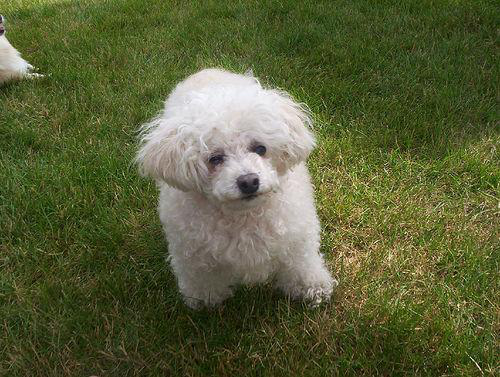

'Race indiquée par les données : toy_poodle'

Race prédite  Probabilité
104  miniature_poodle     0.652671
115        toy_poodle     0.347219
41   Lakeland_terrier     0.000037

#############################################################

Cas n°2


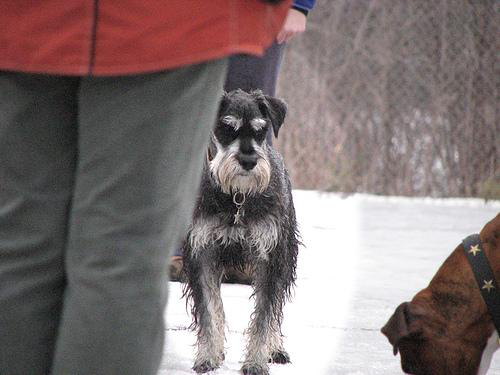

'Race indiquée par les données : standard_schnauzer'

Race prédite   Probabilité
105  miniature_schnauzer  8.540148e-01
114   standard_schnauzer  1.459850e-01
94       giant_schnauzer  1.734081e-07

#############################################################

Cas n°3


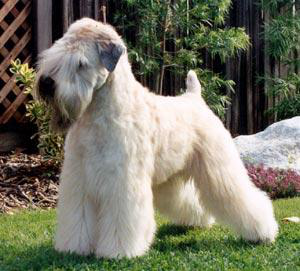

'Race indiquée par les données : Sealyham_terrier'

Race prédite  Probabilité
112  soft-coated_wheaten_terrier     0.956069
61              Sealyham_terrier     0.037118
41              Lakeland_terrier     0.003409

#############################################################

Cas n°4


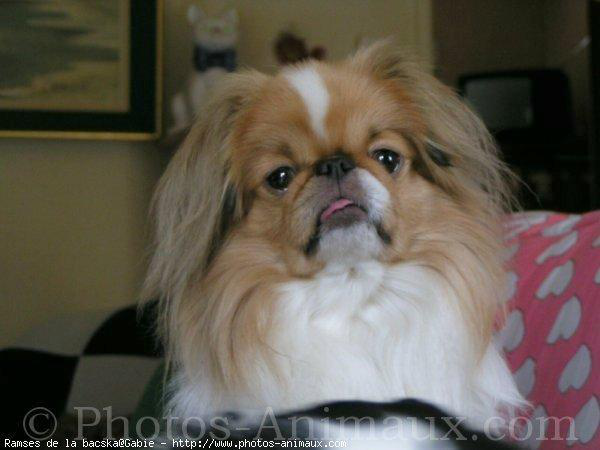

'Race indiquée par les données : Japanese_spaniel'

Race prédite  Probabilité
51          Pekinese     0.682957
38  Japanese_spaniel     0.316960
63          Shih-Tzu     0.000057

#############################################################

Cas n°5


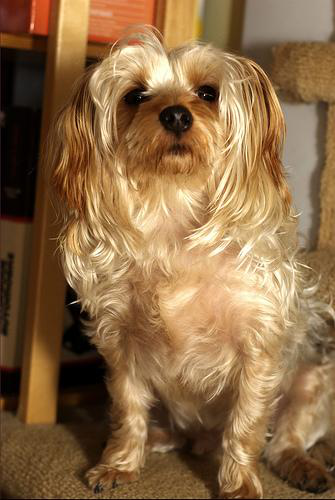

'Race indiquée par les données : Yorkshire_terrier'

Race prédite  Probabilité
111       silky_terrier     0.556029
73    Yorkshire_terrier     0.438189
5    Australian_terrier     0.005672

#############################################################

Cas n°6


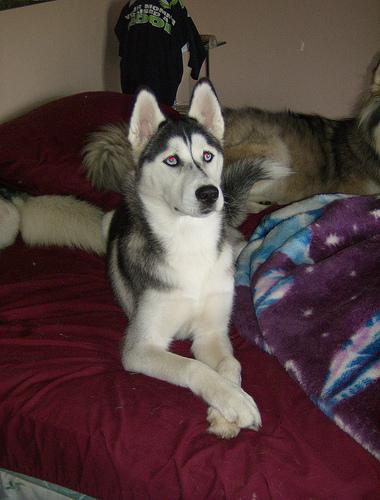

'Race indiquée par les données : Eskimo_dog'

Race prédite  Probabilité
64   Siberian_husky     0.703306
24       Eskimo_dog     0.241923
101        malamute     0.054724

#############################################################

Cas n°7


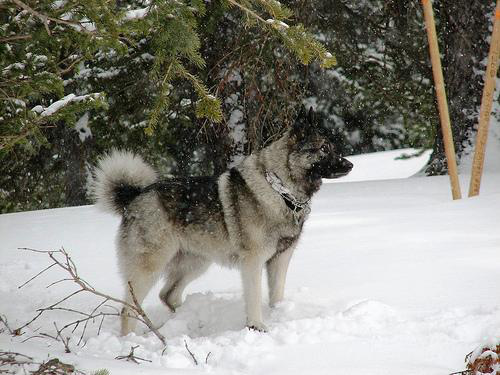

'Race indiquée par les données : Norwegian_elkhound'

Race prédite  Probabilité
101            malamute     0.633134
48   Norwegian_elkhound     0.357203
24           Eskimo_dog     0.006938

#############################################################

Cas n°8


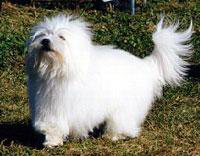

'Race indiquée par les données : Dandie_Dinmont'

Race prédite  Probabilité
68  Tibetan_terrier     0.726645
44      Maltese_dog     0.108285
43            Lhasa     0.054459

#############################################################

Cas n°9


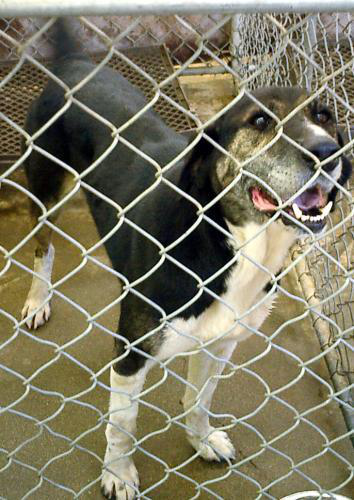

'Race indiquée par les données : Walker_hound'

Race prédite  Probabilité
40     Labrador_retriever     0.055117
29             Great_Dane     0.046484
93  flat-coated_retriever     0.044625

#############################################################

Cas n°10


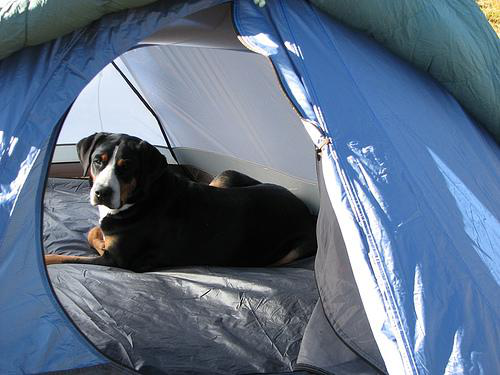

'Race indiquée par les données : Greater_Swiss_Mountain_dog'

Race prédite  Probabilité
23                 EntleBucher     0.616894
31  Greater_Swiss_Mountain_dog     0.232896
4                  Appenzeller     0.139398

#############################################################

Cas n°11


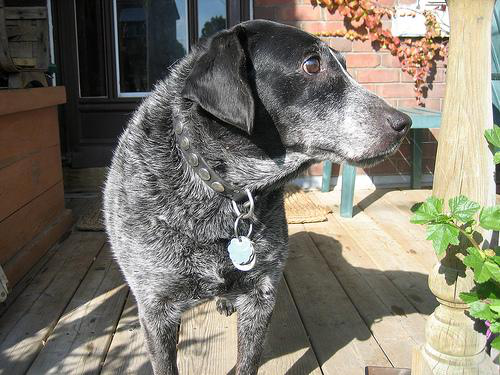

'Race indiquée par les données : bluetick'

Race prédite  Probabilité
27  German_short-haired_pointer     0.770266
80                     bluetick     0.229261
40           Labrador_retriever     0.000402

#############################################################

Cas n°12


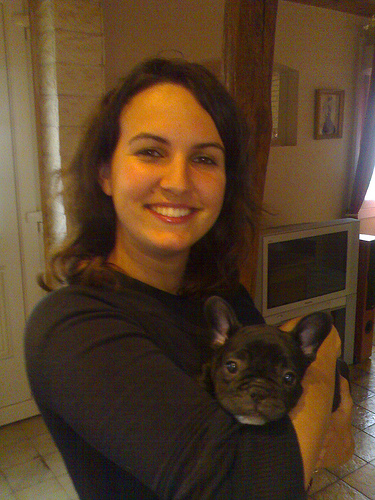

'Race indiquée par les données : French_bulldog'

Race prédite  Probabilité
17            Chihuahua     0.897362
25       French_bulldog     0.070204
103  miniature_pinscher     0.013219

#############################################################

Cas n°13


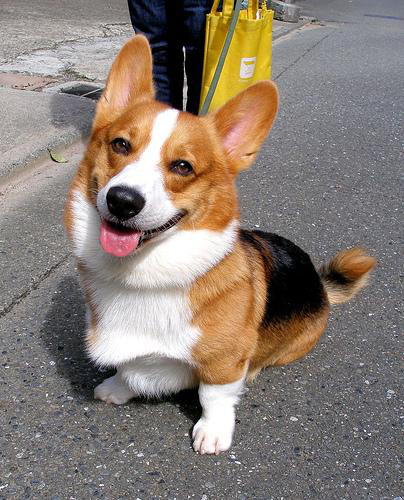

'Race indiquée par les données : Cardigan'

Race prédite  Probabilité
52      Pembroke     0.655918
15      Cardigan     0.344061
107     papillon     0.000019

#############################################################

Cas n°14


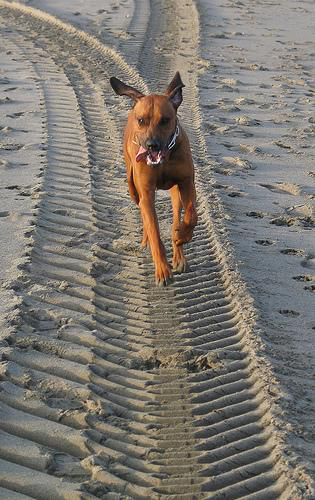

'Race indiquée par les données : Rhodesian_ridgeback'

Race prédite  Probabilité
103  miniature_pinscher     0.354982
116         toy_terrier     0.185896
13    Brabancon_griffon     0.129670

#############################################################

Cas n°15


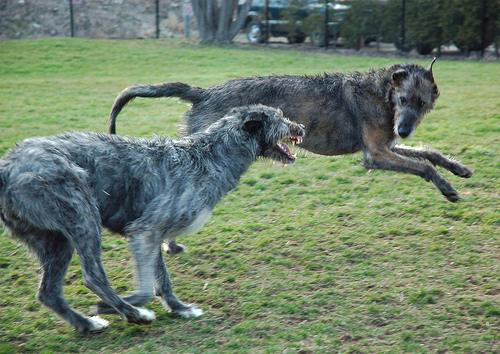

'Race indiquée par les données : Irish_wolfhound'

Race prédite   Probabilité
60   Scottish_deerhound  9.515978e-01
36      Irish_wolfhound  4.840231e-02
118             whippet  6.883455e-10

#############################################################

Cas n°16


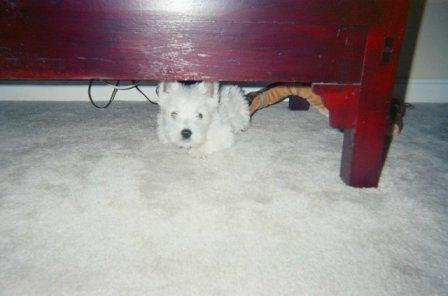

'Race indiquée par les données : West_Highland_white_terrier'

Race prédite  Probabilité
58                      Samoyed     0.662485
72  West_Highland_white_terrier     0.152814
41             Lakeland_terrier     0.054211

#############################################################

Cas n°17


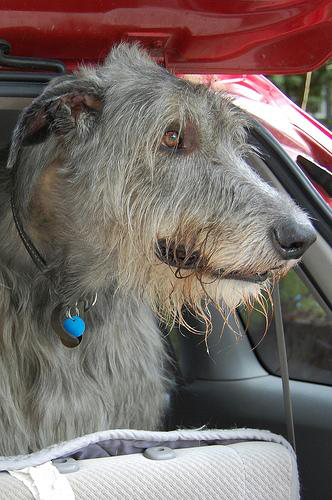

'Race indiquée par les données : Irish_wolfhound'

Race prédite  Probabilité
60  Scottish_deerhound     0.999046
36     Irish_wolfhound     0.000948
81              borzoi     0.000005

#############################################################

Cas n°18


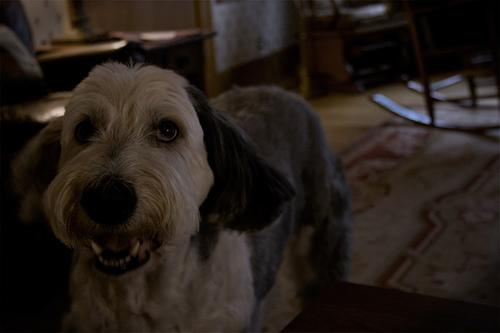

'Race indiquée par les données : Old_English_sheepdog'

Race prédite  Probabilité
106            otterhound     0.450279
68        Tibetan_terrier     0.264938
50   Old_English_sheepdog     0.079104

#############################################################

Cas n°19


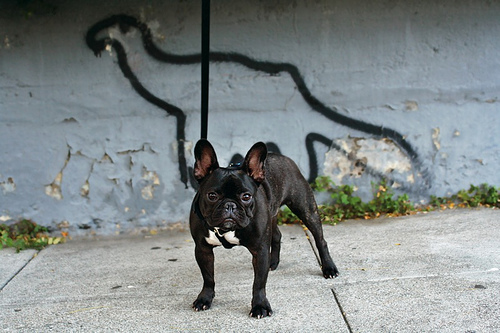

'Race indiquée par les données : French_bulldog'

Race prédite  Probabilité
13    Brabancon_griffon     0.614223
103  miniature_pinscher     0.207547
19             Doberman     0.033202

#############################################################

Cas n°20


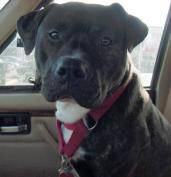

'Race indiquée par les données : American_Staffordshire_terrier'

Race prédite  Probabilité
65       Staffordshire_bullterrier     0.576555
3   American_Staffordshire_terrier     0.423019
40              Labrador_retriever     0.000220

#############################################################



In [7]:
i = 1
for img in error_predict.uri.head(20):
    print(f"Cas n°{i}")
    display(load_img(img))
    display("Race indiquée par les données : " + get_true_breed(img))
    display(get_top3_breeds(model, img))
    print("#############################################################")
    print("")
    i += 1

## 3-2. Retour sur le cas n°3

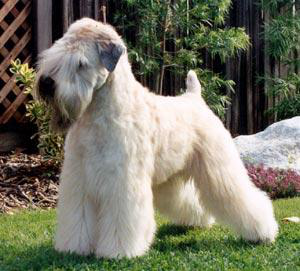

'Race indiquée par les données : Sealyham_terrier'

Race prédite  Probabilité
112  soft-coated_wheaten_terrier     0.956069
61              Sealyham_terrier     0.037118
41              Lakeland_terrier     0.003409

In [8]:
img = error_predict.uri[2]
display(load_img(img))
display("Race indiquée par les données : " + get_true_breed(img))
display(get_top3_breeds(model, img))

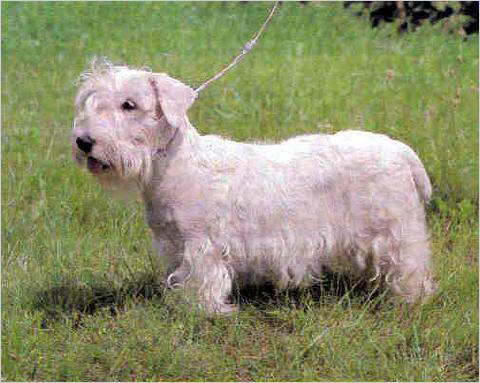

In [9]:
file = 'src/img/n02095889-Sealyham_terrier/n02095889_61.jpg'
display(load_img(file))

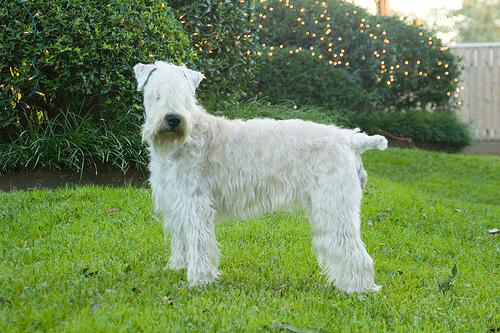

In [10]:
file = 'src/img/n02098105-soft-coated_wheaten_terrier/n02098105_3591.jpg'
display(load_img(file))

Dans ce cas, il s'agit d'une erreur humaine. La photo est dans le mauvais dossier (mauvaise race attribué). Cependant, l'ordinateur a identifié la bonne race.

## 3-3. Retour sur le cas n°12

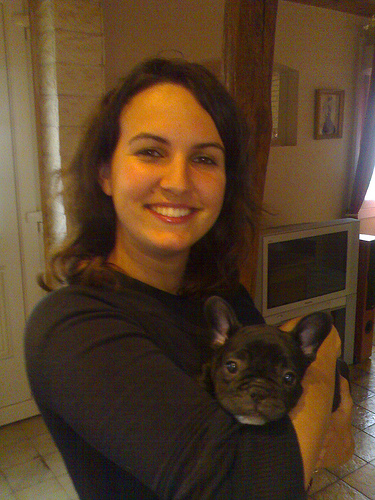

'Race indiquée par les données : French_bulldog'

Race prédite  Probabilité
17            Chihuahua     0.897362
25       French_bulldog     0.070204
103  miniature_pinscher     0.013219

In [11]:
img = error_predict.uri[11]
display(load_img(img))
display("Race indiquée par les données : " + get_true_breed(img))
display(get_top3_breeds(model, img))

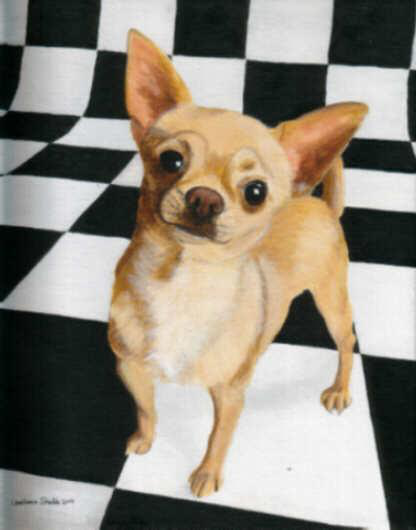

In [12]:
file = 'src/img/n02085620-Chihuahua/n02085620_952.jpg'
display(load_img(file))

En effet, il y a une erreur de prédiction. La race présentée n'est pas un Chihuahua. Renouvelons l'expérience avec la même photo, mais recadrée sur ce que l'on souhaite identifier.

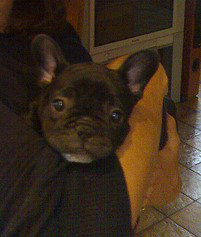

Race prédite   Probabilité
25  French_bulldog  9.999772e-01
17       Chihuahua  2.222577e-05
15        Cardigan  4.017070e-07

In [13]:
img = 'img test api/n02108915_623_recadrée.jpg'
display(load_img(img))
display(get_top3_breeds(model, img))

Une fois la photo recadrée, la machine ne se trompe plus. Pour résoudre ce problème, nous pouvons former l'humain à mieux qualifier les photos à donner à la machine.

---
# 4. Conclusion
En corrigeant les erreurs vues dans les étapes précédentes, nous pouvons encore améliorer considérablement les performances de l'algorithme. Je recommande d'être soigneux dans le choix et l'identification des photos à donner en apprentissage pour la machine, mais aussi en production.

In [14]:
accuracy_best_model = round((test_file.shape[0] - error_predict.shape[0]) / test_file.shape[0]*100, 1)
print(f'Précision du modèle : {accuracy_best_model} %')

Précision du modèle : 87.4 %


In [15]:
class_report = classification_report(test_file.breeds, test_file.predicted_breeds, output_dict=True)
class_report_df = pd.DataFrame.from_dict(class_report, orient='columns').transpose().head(-3)
pd.set_option('display.max_rows', None)
class_report_df.sort_values('precision')

precision    recall  f1-score  support
Tibetan_mastiff                  0.509091  0.933333  0.658824     30.0
Eskimo_dog                       0.538462  0.269231  0.358974     26.0
English_foxhound                 0.568966  0.970588  0.717391     34.0
miniature_poodle                 0.607143  0.680000  0.641509     25.0
Siberian_husky                   0.623188  0.877551  0.728814     49.0
Chesapeake_Bay_retriever         0.659574  0.837838  0.738095     37.0
collie                           0.666667  0.666667  0.666667     27.0
Shih-Tzu                         0.675676  0.862069  0.757576     29.0
Tibetan_terrier                  0.677419  0.933333  0.785047     45.0
American_Staffordshire_terrier   0.703704  0.612903  0.655172     31.0
toy_poodle                       0.714286  0.588235  0.645161     17.0
Rhodesian_ridgeback              0.720000  0.750000  0.734694     24.0
silky_terrier                    0.722222  0.906977  0.804124     43.0
EntleBucher                      0.729167  1.000000  0.843373     35.0
Cardigan                         0.744186  0.888889  0.810127     36.0
Border_collie                    0.758621  0.846154  0.800000     26.0
Lakeland_terrier                 0.767442  0.868421  0.814815     38.0
Norwich_terrier                  0.775000  0.861111  0.815789     36.0
Pekinese                         0.777778  0.903226  0.835821     31.0
Doberman                         0.785714  0.880000  0.830189     25.0
toy_terrier                      0.800000  0.914286  0.853333     35.0
Scottish_deerhound               0.800000  0.878049  0.837209     41.0
Staffordshire_bullterrier        0.800000  0.848485  0.823529     33.0
cocker_spaniel                   0.800000  0.933333  0.861538     30.0
Irish_terrier                    0.804878  0.970588  0.880000     34.0
Chihuahua                        0.805556  0.906250  0.852941     32.0
briard                           0.806452  0.925926  0.862069     27.0
redbone                          0.814815  0.846154  0.830189     26.0
Yorkshire_terrier                0.823529  0.777778  0.800000     36.0
malamute                         0.828571  0.743590  0.783784     39.0
miniature_schnauzer              0.828571  0.852941  0.840580     34.0
bluetick                         0.840909  0.925000  0.880952     40.0
Dandie_Dinmont                   0.846154  0.916667  0.880000     24.0
Brittany_spaniel                 0.850000  0.894737  0.871795     19.0
standard_schnauzer               0.851852  0.766667  0.807018     30.0
Airedale                         0.852941  0.906250  0.878788     32.0
Shetland_sheepdog                0.857143  0.818182  0.837209     22.0
Great_Pyrenees                   0.859649  0.924528  0.890909     53.0
Maltese_dog                      0.862745  0.936170  0.897959     47.0
boxer                            0.866667  1.000000  0.928571     26.0
dingo                            0.868421  0.942857  0.904110     35.0
Italian_greyhound                0.870968  0.771429  0.818182     35.0
Australian_terrier               0.875000  0.777778  0.823529     54.0
Weimaraner                       0.880952  0.973684  0.925000     38.0
Irish_water_spaniel              0.882353  1.000000  0.937500     30.0
Norfolk_terrier                  0.888889  0.800000  0.842105     40.0
groenendael                      0.888889  1.000000  0.941176     32.0
Sealyham_terrier                 0.888889  0.975610  0.930233     41.0
vizsla                           0.888889  0.888889  0.888889     27.0
Pembroke                         0.888889  0.750000  0.813559     32.0
bloodhound                       0.894737  0.944444  0.918919     36.0
Blenheim_spaniel                 0.894737  0.971429  0.931507     35.0
English_setter                   0.894737  0.918919  0.906667     37.0
flat-coated_retriever            0.900000  0.964286  0.931034     28.0
miniature_pinscher               0.902439  0.804348  0.850575     46.0
Welsh_springer_spaniel           0.903226  1.000000  0.9